<a href="https://colab.research.google.com/github/hyomee2/scooter-parking-detector/blob/main/pipeline/final_yolo_resnet_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 1. 초기 설정

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
import torch
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from ultralytics import YOLO

# 모델 경로 설정
yolo_model_path = '/content/gdrive/MyDrive/result/yolov8n_finetune3/weights/best.pt'
model_stage1_path = '/content/gdrive/MyDrive/resnet/best_stage1_resnet50.h5'
model_stage2_path = '/content/gdrive/MyDrive/resnet/best_stage2_resnet50_focused_improper.h5'
test_data_root_dir = '/content/gdrive/MyDrive/dataset/cnn/test'

# resnet의 입력 이미지 크기
model_input_size = (224, 224)

# 이전에 mobilenet에서 검증 데이터로 찾은 최적의 임계값 (resnet 코드 참고)
BEST_THRESHOLD = 0.01

# 최종 3개 클래스 이름 (출력 시 사용)
# 이 순서가 최종 매핑 (0:improper, 1:noise, 2:proper)과 일치해야 합니다.
final_class_names = ['improper', 'noise', 'proper']

# 클래스 이름과 인덱스 매핑 (실제값 비교를 위해)
# 이 매핑은 'final_class_names' 순서와 일치해야 합니다.
class_to_idx = {'improper': 0, 'noise': 1, 'proper': 2}

## 2. 모델 불러오기

In [ ]:
# YOLO 모델 불러오기
print("YOLO 모델 불러오는 중 (YOLOv8)...")
try:
    yolo_model = YOLO(yolo_model_path)
    print("YOLO 모델 로드 완료")
except Exception as e:
    print(f"YOLO 모델 로드 중 오류 발생: {e}")
    exit()

# resnet 불러오기
print("\n resnet 모델 불러오는 중")
try:
    model_stage1 = load_model(model_stage1_path)
    model_stage2 = load_model(model_stage2_path)
    print("resnet모델 로드 완료.")
except Exception as e:
    print(f"2단계 분류 모델 로드 중 오류 발생: {e}")
    exit()

YOLO 모델 불러오는 중 (YOLOv8)...
YOLO 모델 로드 완료

 resnet 모델 불러오는 중


resnet모델 로드 완료.


## 3. 이미지 전처리 및 분류 수행

In [ ]:
print(f"\n'{test_data_root_dir}'에서 이미지 탐지 및 분류 수행 중...")

all_ground_truths = []
all_predictions = []
all_logits = []  # 최종 3개 클래스 확률 저장

image_paths_with_labels = []
for root, dirs, files in os.walk(test_data_root_dir):
    current_label_name = os.path.basename(root)
    if current_label_name in class_to_idx:
        ground_truth_idx = class_to_idx[current_label_name]
        for fname in files:
            if fname.lower().endswith(('.jpg')):
                full_path = os.path.join(root, fname)
                image_paths_with_labels.append((full_path, ground_truth_idx, current_label_name))

if not image_paths_with_labels:
    print(f"경고: '{test_data_root_dir}' 폴더 및 하위 폴더에 처리할 이미지가 없습니다. 경로와 구조를 확인해주세요.")
else:
    for img_path, ground_truth_idx, ground_truth_name in image_paths_with_labels:
        img_original = cv2.imread(img_path)
        if img_original is None:
            print(f"경고: 이미지를 읽을 수 없습니다 - {img_path}. 파일 손상 또는 권한 문제일 수 있습니다.")
            continue

        print(f"\n--- 원본 이미지 처리 중: {os.path.basename(img_path)} (실제값: {ground_truth_name}) ---")

        # YOLOv8로 탐지 수행 (verbose=False)
        results = yolo_model(img_original, verbose=False)

        detected_bboxes = []
        for r in results:
            boxes = r.boxes.xyxy.cpu().numpy()
            for i, bbox in enumerate(boxes):
                x1, y1, x2, y2 = map(int, bbox[:4])
                if x2 > x1 and y2 > y1:
                    bbox_area = (x2 - x1) * (y2 - y1)
                    detected_bboxes.append((x1, y1, x2, y2, bbox_area))

        if not detected_bboxes:
            print(f"정보: 원본 이미지 '{os.path.basename(img_path)}'에서 스쿠터를 탐지하지 못했습니다.")
            predicted_class_index = class_to_idx['noise']
            final_predicted_name = final_class_names[predicted_class_index]

            all_ground_truths.append(ground_truth_idx)
            all_predictions.append(predicted_class_index)
            all_logits.append(np.array([0.0, 1.0, 0.0]))  # noise 확률 1로 기록
            print(f"-> 예측값: {final_predicted_name}")
            continue

        largest_bbox_info = sorted(detected_bboxes, key=lambda x: x[4], reverse=True)[0]
        x1, y1, x2, y2, _ = largest_bbox_info

        cropped_bgr = img_original[y1:y2, x1:x2]
        cropped_rgb = cv2.cvtColor(cropped_bgr, cv2.COLOR_BGR2RGB)

        img_resized = cv2.resize(cropped_rgb, model_input_size)
        img_array = image.img_to_array(img_resized)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        # Stage 1 예측: 'no_kickboard' (0) vs 'has_kickboard' (1) 확률
        stage1_pred_prob = model_stage1.predict(img_array, verbose=0).flatten()[0]
        stage1_binary_pred = (stage1_pred_prob > BEST_THRESHOLD).astype(int)

        predicted_class_index = class_to_idx['noise']  # 기본값

        if stage1_binary_pred == 1:
            stage2_pred_probs = model_stage2.predict(img_array, verbose=0)
            stage2_pred_class_index = np.argmax(stage2_pred_probs, axis=1)[0]

            if stage2_pred_class_index == 0:
                predicted_class_index = class_to_idx['improper']
            else:
                predicted_class_index = class_to_idx['proper']

        # all_logits 계산
        p_noise = 1 - stage1_pred_prob
        p_kickboard = stage1_pred_prob
        if stage1_binary_pred == 1:
            final_probs = np.array([
                p_kickboard * stage2_pred_probs[0][0],  # improper
                p_noise,                                # noise
                p_kickboard * stage2_pred_probs[0][1]  # proper
            ])
        else:
            final_probs = np.array([0.0, 1.0, 0.0])  # noise 확률 1

        all_ground_truths.append(ground_truth_idx)
        all_predictions.append(predicted_class_index)
        all_logits.append(final_probs)

        final_predicted_name = final_class_names[predicted_class_index]
        print(f"-> 예측값: {final_predicted_name} (Stage1 Kickboard 확률: {stage1_pred_prob:.2f})\n")

print("\n--- 모든 이미지 처리 완료 ---")


--- 원본 이미지 처리 중: D009.jpg (실제값: improper) ---
-> 예측값: improper (Stage1 Kickboard 확률: 0.99)


--- 원본 이미지 처리 중: hm95.jpg (실제값: improper) ---
-> 예측값: proper (Stage1 Kickboard 확률: 1.00)


--- 원본 이미지 처리 중: hm33.jpg (실제값: improper) ---
-> 예측값: improper (Stage1 Kickboard 확률: 1.00)


--- 원본 이미지 처리 중: 271.jpg (실제값: improper) ---
-> 예측값: improper (Stage1 Kickboard 확률: 0.99)


--- 원본 이미지 처리 중: B013.jpg (실제값: improper) ---
-> 예측값: improper (Stage1 Kickboard 확률: 0.98)


--- 원본 이미지 처리 중: hm49.jpg (실제값: improper) ---
-> 예측값: improper (Stage1 Kickboard 확률: 0.98)


--- 원본 이미지 처리 중: hm148.jpg (실제값: improper) ---
-> 예측값: improper (Stage1 Kickboard 확률: 0.96)


--- 원본 이미지 처리 중: hm22.jpg (실제값: improper) ---
-> 예측값: improper (Stage1 Kickboard 확률: 0.96)


--- 원본 이미지 처리 중: 225.jpg (실제값: improper) ---
-> 예측값: improper (Stage1 Kickboard 확률: 0.93)


--- 원본 이미지 처리 중: hm29.jpg (실제값: improper) ---
-> 예측값: improper (Stage1 Kickboard 확률: 0.96)


--- 원본 이미지 처리 중: hm133.jpg (실제값: improper) ---
-> 예측값: improper (Stage1 

## 4. 시각화


총 처리된 이미지 수: 111
전체 정답률 (Accuracy): 95.50%
[[28  0  4]
 [ 0 15  0]
 [ 1  0 63]]


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47148 (\N{HANGUL SYLLABLE RYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


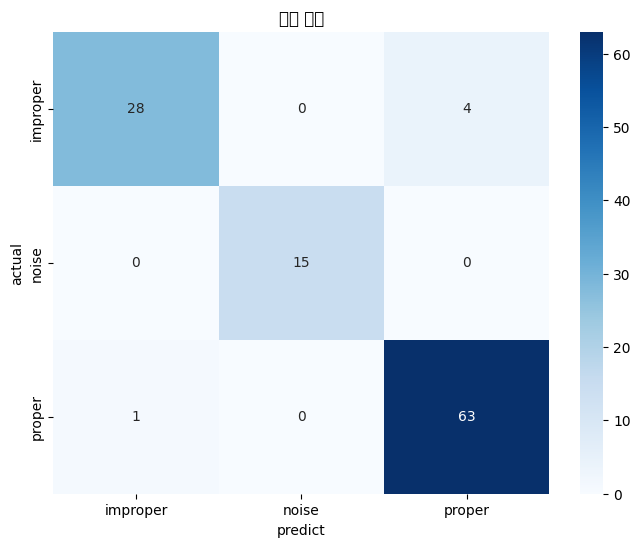

              precision    recall  f1-score   support

    improper       0.97      0.88      0.92        32
       noise       1.00      1.00      1.00        15
      proper       0.94      0.98      0.96        64

    accuracy                           0.95       111
   macro avg       0.97      0.95      0.96       111
weighted avg       0.96      0.95      0.95       111

AUC (macro, ovr): 0.9932


In [ ]:
# 혼동 행렬을 위한 라이브러리 추가
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 정답률 및 혼동 행렬 계산 및 출력

if len(all_ground_truths) > 0:
    # 정확도 출력
    accuracy = accuracy_score(all_ground_truths, all_predictions) * 100
    print(f"\n총 처리된 이미지 수: {len(all_ground_truths)}")
    print(f"전체 정답률 (Accuracy): {accuracy:.2f}%")

    # 혼동 행렬 계산 및 시각화
    cm = confusion_matrix(all_ground_truths, all_predictions)
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=final_class_names, yticklabels=final_class_names)
    plt.xlabel('predict')
    plt.ylabel('actual')
    plt.title('혼동 행렬')
    plt.show()

    # 분류 보고서 출력
    print(classification_report(all_ground_truths, all_predictions, target_names=final_class_names))

    # AUC 계산 (One-vs-Rest, Macro)
    # all_logits: 리스트 -> numpy 배열 (N x 3)
    all_logits_np = np.array(all_logits)

    try:
        auc_macro = roc_auc_score(
            np.eye(len(final_class_names))[all_ground_truths],  # one-hot encoding
            all_logits_np,
            average='macro',
            multi_class='ovr'
        )
        print(f"AUC (macro, ovr): {auc_macro:.4f}")
    except Exception as e:
        print(f"AUC 계산 중 오류 발생: {e}")

else:
    print("\n처리된 이미지가 없어 정답률 및 혼동 행렬을 계산할 수 없습니다.")